# Scheduling 

There is a single process to be optimized for cost [USD] over 4 quarters of a year. 
There is variability in terms of how much of the (known) process [Wind Farm] capacity can be accessed, and resource (Power) demand.


## Initialize

In [25]:
# !pip install energiapy # uncomment and run to install Energia, if not in environment
from energia import *

m = Model('scheduling')

## Time

We have 4 quarter which form a year

In [26]:
m.q = Periods()
m.y = 4 * m.q

The horizon ($\overset{\ast}{t} = argmin_{n \in N} |\mathcal{T}_{n}|$) is determined by Energia implicitly. Check it by printing Model.Horizon

In [27]:
m.horizon

y

## Space

If nothing is provided, a default location is created. The created single location will serve as the de facto network

In single location case studies, it may be easier to skip providing a location all together 

In [28]:
m.network

l0

## Resources

In the Resource Task Network (RTN) methodology all commodities are resources. In this case, we have a few general resources (wind, power) and a monetary resource (USD).

In [29]:
m.usd = Currency()

### Setting Bounds

The first bound is set for over the network and year, given that no spatiotemporal disposition is provided: 

$\mathbf{cons}_{wind, network, year_0} \leq 400$ 

For the second bound, given that a nominal is given, the list is treated as multiplicative factor. The length matches with the quarterly scale. Thus:

$\mathbf{rlse}_{power, network, quarter_0} \geq 60$

$\mathbf{rlse}_{power, network, quarter_1} \geq 70$

$\mathbf{rlse}_{power, network, quarter_2} \geq 100$

$\mathbf{rlse}_{power, network, quarter_3} \geq 30$


In [30]:
m.power = Resource(demand_nominal=100, demand_min=[0.6, 0.7, 1, 0.3])
m.wind = Resource(consume_max=400)

⚖   Initiated power balance in (l0, q)                                      ⏱ 0.0002 s
🔗  Bound [≥] power release in (l0, q)                                       ⏱ 0.0013 s
⚖   Initiated wind balance in (l0, y)                                       ⏱ 0.0002 s
🔗  Bound [≤] wind consume in (l0, y)                                        ⏱ 0.0008 s


This is the same as:

In [31]:
# m.wind.consume <= 400
# m.power.release.prep(100) >= [0.6, 0.7, 1, 0.3]

In [32]:
m.y.show(True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Check the model anytime, using m.show(), or object.show()

The first constraint is a general resource balance, generated for every resource at every spatiotemporal disposition at which an aspect regarding it is defined. 

Skip the True in .show() for a more concise set notation based print

In [33]:
m.power.show(True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Process 

There are multiple ways to model this.

Whats most important, however, is the resource balance. The resource in the brackets is the basis resource. For a negative basis, multiply the resource by the negative factor or just use negation if that applies. 


You can set bounds on the extent to which the wind farm can operate. We are actually writing the following constraint: 

$\mathbf{opr} <= \phi \cdot \mathbf{cap}$

However, we know the capacity, so it is treated as a parameter. 

Note that the incoming values are normalized by default. Use norm = False to avoid that

### Operating Level as Decision

In [ ]:
m.wf = Process(
    m.power == -1 * m.wind,
    operate_nominal=200,
    operate_normalize=False,
    operate_max=[0.9, 0.8, 0.5, 0.7],
    opex=[4000, 4200, 4300, 3900],
)

🔗  Bound [≤] wf operate in (l0, q)                                          ⏱ 0.0003 s
🧭  Mapped time for operate (wf, l0, q) ⟺ (wf, l0, y)                        ⏱ 0.0002 s
🔗  Bound [=] usd spend in (l0, q)                                           ⏱ 0.0008 s


Is the same as:

m.wf = Process()
m.wf(m.power) == -1 * m.wind
m.wf.operate.prep(200, norm=False) <= [0.9, 0.8, 0.5, 0.7]
m.wf.show(True)

In [35]:
# m.wf = Process()
# m.wf(m.power) == -1 * m.wind
# m.wf.operate.prep(200, norm=False) <= [0.9, 0.8, 0.5, 0.7]
# m.wf.show(True)

### Capacity and Operating Level as Decisions

In [36]:
# m.wf.capacity == True
# m.wf.operate <= [0.9, 0.8, 0.5, 0.7]
# m.wf.show(True)

### Fixed Capacity and Operating Level as Decision

In [37]:
# m.wf.capacity == 200
# m.wf.operate <= [0.9, 0.8, 0.5, 0.7]
# m.wf.show(True)

### General Calculations

Any general calculation can be computed as

Add a cost to the process operation. This implies that the cost of operating is variable in every quarter. In general:

$\dot{\mathbf{v}} == \theta \cdot \mathbf{v}$

In [38]:
# m.usd.spend(m.wf.operate) == [4000, 4200, 4300, 3900]

In [39]:
m.operate.show()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Note that printing can be achieved via the aspect [operate, spend, etc.] or the object

## Locating the process

The production streams are only generated once the process is places in some location. In this study, the only location is available is the default network.

In [40]:
m.network.locate(m.wf)

💡  Assumed wf capacity unbounded in (l0, y)                                 ⏱ 0.0002 s
💡  Assumed wf operate bounded by capacity in (l0, q)                        ⏱ 0.0001 s
⚖   Updated power balance with produce(power, l0, q, operate, wf)           ⏱ 0.0002 s
🔗  Bound [=] power produce in (l0, q)                                       ⏱ 0.0010 s
⚖   Updated wind balance with expend(wind, l0, y, operate, wf)              ⏱ 0.0002 s
🔗  Bound [=] wind expend in (l0, y)                                         ⏱ 0.0013 s
🏭  Operating streams introduced for wf in l0                                ⏱ 0.0046 s
🏗   Construction streams introduced for wf in l0                            ⏱ 0.0000 s
🌍  Located wf in l0                                                         ⏱ 0.0081 s


Alternatively,

In [41]:
# m.wf.locate(m.network)

# The Model

The model consists of the following:

1. A general resource balances for wind in (network, year) and power in (network, quarter)
2. Bounds on wind consumption [upper] and power release [lower], and wf operation [upper]
3. Conversion constraints, giving produced and expended resources based on operation
4. Calculation of spending USD in every quarter
5. Mapping constraints for operate: q -> y and spend: q -> y (generated after objective is set)


In [42]:
m.show(True)

# Mathematical Program for Program(scheduling)

<br><br>

## Index Sets

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<br><br>

## s.t.

### Balance Constraints

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Binds Constraints

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Calculations Constraints

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Mapping Constraints

<IPython.core.display.Math object>

## Optimize

For maximization use opt(False)

In [43]:
m.usd.spend.opt()

🧭  Mapped time for spend (usd, l0, q, operate, wf) ⟺ (usd, l0, y)           ⏱ 0.0003 s
📝  Generated Program(scheduling).mps                                        ⏱ 0.0020 s


Read MPS format model from file Program(scheduling).mps
Reading time = 0.00 seconds
PROGRAM(SCHEDULING): 25 rows, 20 columns, 47 nonzeros


📝  Generated gurobipy model. See .formulation                               ⏱ 0.0059 s


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 25 rows, 20 columns and 47 nonzeros
Model fingerprint: 0xea244414
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 4e+02]
Presolve removed 25 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0810000e+06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.081000000e+06


📝  Generated Solution object for Program(scheduling). See .solution         ⏱ 0.0002 s
✅  Program(scheduling) optimized using gurobi. Display using .output()      ⏱ 0.0146 s


## The Solution

### The overall

In [44]:
m.output()

# Solution for Program(scheduling)

<br><br>

## Objective

<IPython.core.display.Math object>

<br><br>

## Variables

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Individual

The individual solutions can be obtained as list as well (using aslist = True)

In [45]:
m.operate.output()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Plotting 

There are two plots natively available: line and bar

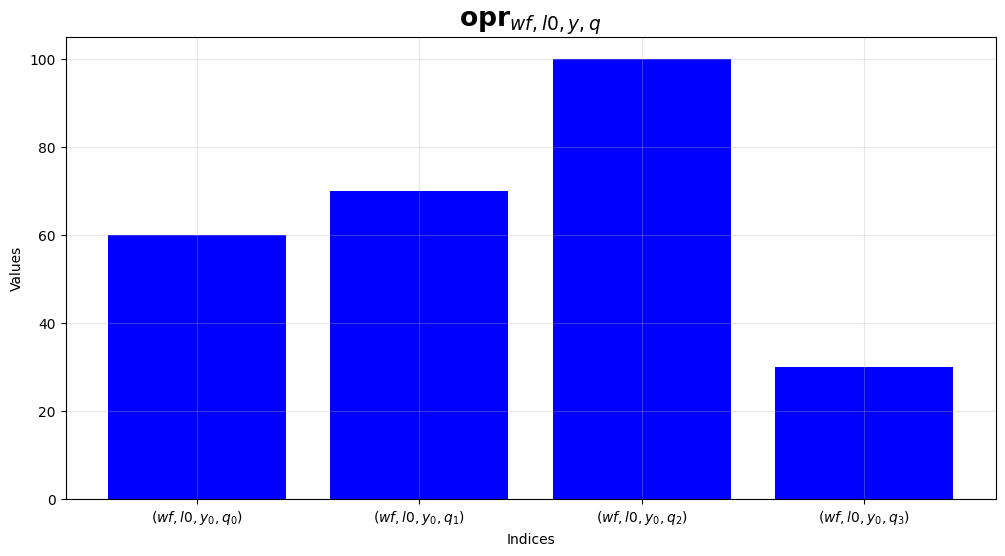

In [46]:
m.operate(m.wf, m.l0, m.q).bar()

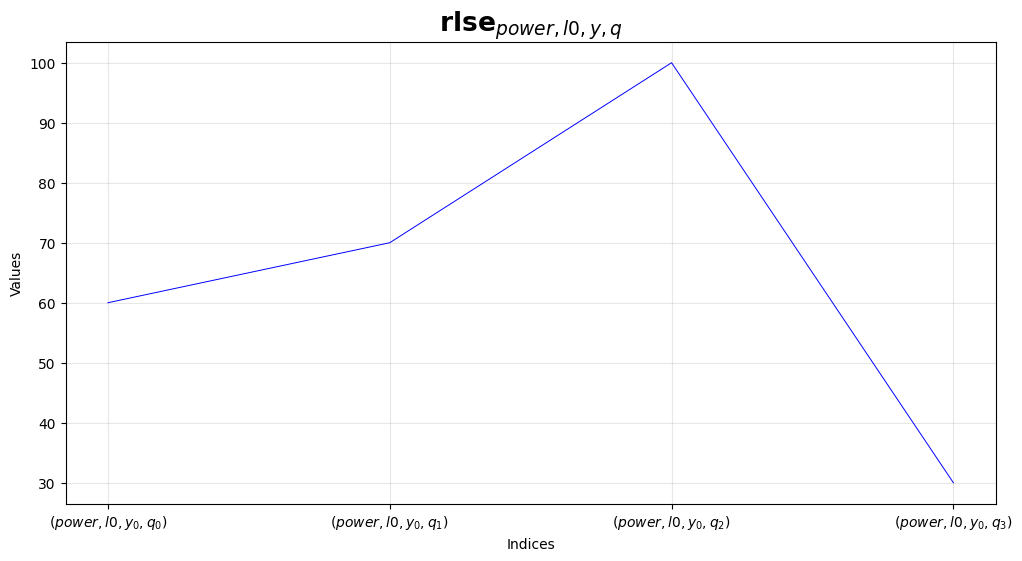

In [ ]:
m.power.release(m.l0, m.q).line()
# same as m.release(m.power, m.l0, m.q).line()